# 06. 사이킷런으로 수행하는 타이타닉 생존자 예측

# 129 페이지 타이타닉 데이터로 분류 모델
- 전처리 : 스케일링
- 교차검증 : cross_val_score()

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


## data load

In [62]:
titanic_df = pd.read_csv('titanic_train.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [63]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## 전처리

## 결측치
- Age : 평균값
- Cabin : N
- Embarked : N

In [64]:
titanic_df['Age'] = titanic_df['Age'].fillna( titanic_df['Age'].mean())
titanic_df['Cabin'] = titanic_df['Cabin'].fillna( 'N')
titanic_df['Embarked'] = titanic_df['Embarked'].fillna( 'N')

titanic_df.isnull().sum().sum()

np.int64(0)

## drop
-PassengerId  
-Name   
-Ticket             

In [65]:

titanic_df = titanic_df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,N,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,N,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,N,S


## 데이터 탐색

In [66]:
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

<Axes: xlabel='Sex', ylabel='Survived'>

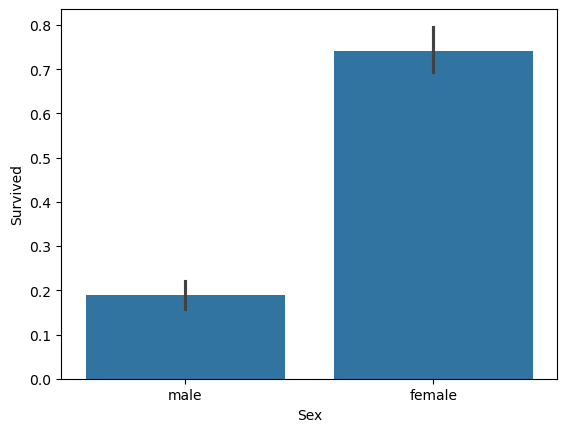

In [67]:
sns.barplot(x='Sex', y = 'Survived', data=titanic_df)

> 분석
- 가설 : 성별에 따라 생존율이 다를 것이다.
- 결과 : 여성의 생존률이 더 높음.

<Axes: xlabel='Pclass', ylabel='Survived'>

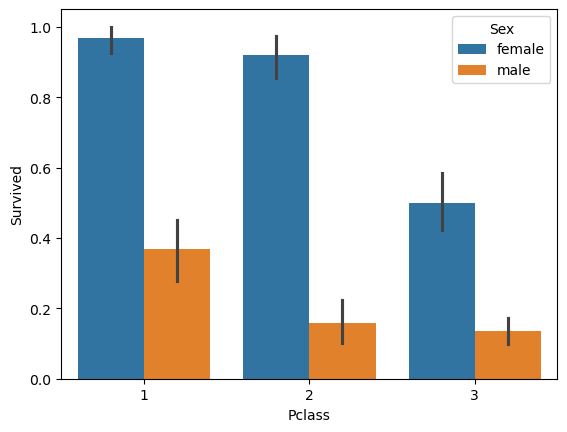

In [68]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)

> 분석
- 가설 : 객실 등급에 따라 생존 확률이 다를 것이다.
- 결과 :  
        - 여성의 경우 1, 2등실에 따른 생존 확률의 차이는 크지 않으나, 삼등실의 경우 생존 확률이 상대적으로 많이 떨어짐.  
        - 남성의 경우, 일등실의 생존 확률이 이, 삼등실의 생존 확률보다 월등히 높음.

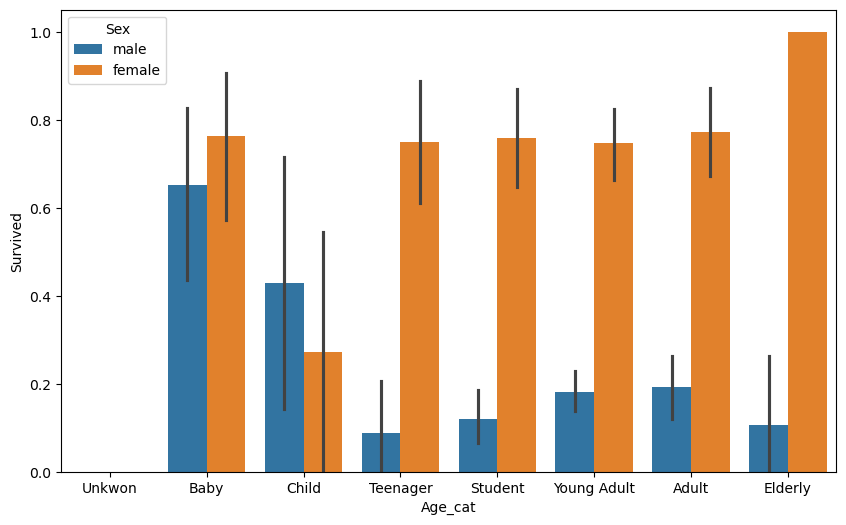

In [69]:
# 입력 age에 따라 구분 값을 반환하는 함수 설정. DataFrame의 apply lambda 식에 사용

def get_category(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age <=5: cat = 'Baby'
    elif age <=12: cat = 'Child'
    elif age <=18: cat = 'Teenager'
    elif age <=25: cat = 'Student'
    elif age <=35: cat = 'Young Adult'
    elif age <=60: cat = 'Adult'
    else: cat = 'Elderly'

    return cat

# 막대그래프의 크기 figure를 더 크게 설정
plt.figure(figsize=(10, 6))

# x축의 값을 순차적으로 표시하기 위한 설정
group_names = ['Unkwon', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda 식에 위에서 생성한 get_category 함수를 반환값으로 지정
# get_category(x)는 입력값으로 'Age' 칼럼 값을 받아서 해당하는 cat 반환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=titanic_df, order=group_names)
titanic_df.drop('Age_cat', axis=1, inplace=True)

> 분석
- 여자 Baby의 경우 비교적 생존 확률이 높지만 여자 Child의 경우 다른 연령대에 비해 생존 확률이 낮음. 여자 Elderly의 경우 매우 생존 확률이 높음
- Sex, Age, PClass 등이 중요하게 생존을 좌우하는 피처임.

## lable encoding - 범주형

In [70]:
print(titanic_df['Sex'].value_counts())
print(titanic_df['Cabin'].value_counts())
print(titanic_df['Embarked'].value_counts())

Sex
male      577
female    314
Name: count, dtype: int64
Cabin
N              687
G6               4
C23 C25 C27      4
B96 B98          4
F2               3
              ... 
E17              1
A24              1
C50              1
B42              1
C148             1
Name: count, Length: 148, dtype: int64
Embarked
S    644
C    168
Q     77
N      2
Name: count, dtype: int64


In [71]:
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
titanic_df.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,N,S
1,1,1,female,38.0,1,0,71.2833,C,C


In [72]:
col_names = ['Cabin', 'Sex', 'Embarked']
for col in col_names:
    le = LabelEncoder()
    le.fit(titanic_df[col])
    titanic_df[col] = le.transform(titanic_df[col])

titanic_df.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,7,3
1,1,1,0,38.0,1,0,71.2833,2,0


## 피처 가공 프로세스 함수화

In [73]:
# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행. 
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

## Age, Fare - 수치형
1. 그대로(As-Is) : 데이터를 그대로 사용하는 것
2. 스케일링(Scaling): 데이터의 범위를 조정하는 것(정규화, 표준화)
3. 비닝(Binning): 연속형 데이터를 구간으로 나누는 것

In [74]:
X_titanic_df = titanic_df.drop('Survived', axis=1)
y_titanic_df = titanic_df['Survived']


In [75]:
# 교재 방법
# 원본 데이터를 재로딩 하고, feature데이터 셋과 Label 데이터 셋 추출. 
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived',axis=1)

X_titanic_df = transform_features(X_titanic_df)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_30692\516752281.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].mean(),inplace=True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_30692\516752281.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

## 분할

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

## 학습

In [77]:
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression(solver='liblinear')

In [78]:
dt_clf.fit(X_train, y_train )
rf_clf.fit(X_train, y_train)
lr_clf.fit(X_train, y_train)

dt_pred = dt_clf.predict(X_test )
rf_pred = rf_clf.predict(X_test)
lr_pred = lr_clf.predict(X_test)

accuracy_score(y_test, dt_pred), accuracy_score(y_test, rf_pred), accuracy_score(y_test, lr_pred)

(0.7877094972067039, 0.8547486033519553, 0.8659217877094972)

## 교차검증

### KFold

In [79]:
dt_clf_cv = DecisionTreeClassifier(random_state=11)
rf_clf_cv = RandomForestClassifier(random_state=11)
lr_clf_cv = LogisticRegression(solver='liblinear')

In [80]:
# 폴드 세트를 5개인 KFold 객체를 생성, 폴드 수만큼 예측 결과 저장을 위한 리스트 객체 생성
kfold = KFold(n_splits=5) #stratified
scores = []

# KFold 교차 검증 수행
for train_index, test_index in kfold.split(X_titanic_df) :
    # X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
    X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
    y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
    # cLASSIFIER 학습, 예측, 정확도 계산
    dt_clf_cv.fit(X_train, y_train )
    dt_pred = dt_clf_cv.predict(X_test )
    scores.append(accuracy_score(y_test, dt_pred))
   
print(scores)
print('평균 정확도 : ', np.mean(scores))


[0.7541899441340782, 0.7808988764044944, 0.7865168539325843, 0.7696629213483146, 0.8202247191011236]
평균 정확도 :  0.782298662984119


In [81]:
# 함수로 만들기 = 141P
def exec_kfold(clf, folds=5):
    # 폴드 세트를 5개인 KFold객체를 생성, 폴드 수만큼 예측결과 저장을 위한  리스트 객체 생성.
    kfold = KFold(n_splits=folds)
    scores = []
    
    # KFold 교차 검증 수행. 
    for iter_count , (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
        # X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
        
        # Classifier 학습, 예측, 정확도 계산 
        clf.fit(X_train, y_train) 
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))     
    
    # 5개 fold에서의 평균 정확도 계산. 
    mean_score = np.mean(scores)
    print("평균 정확도: {0:.4f}".format(mean_score)) 
# exec_kfold 호출
exec_kfold(dt_clf , folds=5) 

교차 검증 0 정확도: 0.7542
교차 검증 1 정확도: 0.7809
교차 검증 2 정확도: 0.7865
교차 검증 3 정확도: 0.7697
교차 검증 4 정확도: 0.8202
평균 정확도: 0.7823


### cross_val_score()

In [31]:
dt_clf_gcv = DecisionTreeClassifier(random_state=11)
rf_clf_gcv = RandomForestClassifier(random_state=11)
lr_clf_gcv = LogisticRegression(solver='liblinear')

In [82]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic_df , y_titanic_df , cv=5)
for iter_count,accuracy in enumerate(scores):
    print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))

print("평균 정확도: {0:.4f}".format(np.mean(scores)))

교차 검증 0 정확도: 0.7430
교차 검증 1 정확도: 0.7753
교차 검증 2 정확도: 0.7921
교차 검증 3 정확도: 0.7865
교차 검증 4 정확도: 0.8427
평균 정확도: 0.7879


## 파라미터 튜닝 + 교차검증 
GridSearchCV(dt_clf_gcv, param_grid= p)

In [83]:
#DecisionTree parameter, 
parameters = { 'max_depth':[1,2,3], 'min_samples_split':[2,3] }
grid_dt_clf = GridSearchCV(dt_clf_gcv, param_grid= parameters, scoring='accuracy', cv=5)
grid_dt_clf.fit(X_train, y_train)

score_df = pd.DataFrame(grid_dt_clf.cv_results_)
score_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003195,0.001606,0.003606,0.001622,1,2,"{'max_depth': 1, 'min_samples_split': 2}",0.804196,0.762238,0.825175,0.774648,0.746479,0.782547,0.028501,3
1,0.001793,0.000394,0.002410,0.001377,1,3,"{'max_depth': 1, 'min_samples_split': 3}",0.804196,0.762238,0.825175,0.774648,0.746479,0.782547,0.028501,3
2,0.003397,0.001016,0.001999,0.000632,2,2,"{'max_depth': 2, 'min_samples_split': 2}",0.748252,0.762238,0.825175,0.774648,0.746479,0.771358,0.028786,5
3,0.001414,0.000505,0.001792,0.001154,2,3,"{'max_depth': 2, 'min_samples_split': 3}",0.748252,0.762238,0.825175,0.774648,0.746479,0.771358,0.028786,5
4,0.001806,0.000755,0.001194,0.000393,3,2,"{'max_depth': 3, 'min_samples_split': 2}",0.797203,0.804196,0.818182,0.795775,0.774648,0.798001,0.014118,1
5,0.001603,0.000800,0.000997,0.000002,3,3,"{'max_depth': 3, 'min_samples_split': 3}",0.797203,0.804196,0.818182,0.795775,0.774648,0.798001,0.014118,1


In [84]:
best_dt_clf = grid_dt_clf.best_estimator_
best_dt_pred = best_dt_clf.predict(X_test)
accuracy_score(y_test, best_dt_pred)

0.8426966292134831

# 평가

## 정확도 높이기 - 튜닝

- 스케일링
- 속성선택

- model : RF, LR
- 파라미터